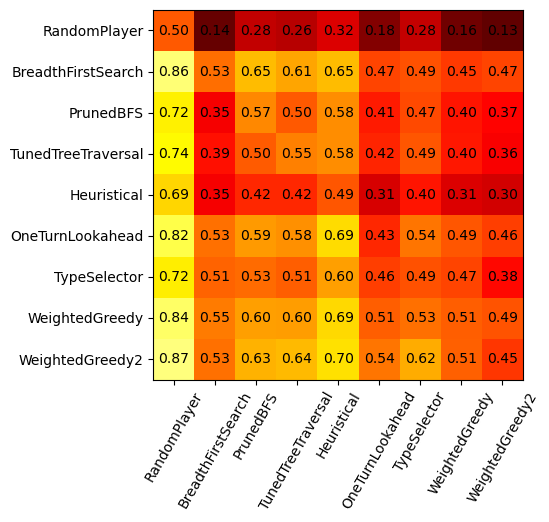

In [21]:
# read 

directory = "data/parallel/20_20"

# open all json files and parse them
import json
import os

data = []
for filename in os.listdir(directory):
    if filename.endswith(".json"):
        with open(os.path.join(directory, filename)) as f:
            data.append(json.load(f))

# map all data in the grid
# they all the combination of policies versus a different policy
# I want to map them in a grid showing the win rate

import numpy as np
import matplotlib
import matplotlib.pyplot as plt

# get all the policies
policies = set()
for d in data:
    policies.add(d["policies_names"][0])

policies = list(policies)
index_policy = {k: i for i, k in enumerate(policies)}
# create the grid
grid = np.zeros((len(policies), len(policies)))

for d in data:
    x, y = index_policy[d["policies_names"][0]], index_policy[d["policies_names"][1]]
    # calculate the win rate
    wins = 0
    for battle in d["battles"]:
        if battle["result"] == 0:
            wins += 1
    grid[x, y] = wins / len(d["battles"])
    grid[y, x] = 1 - grid[x, y]

plt.figure(1)
plt.imshow(grid, cmap='hot', interpolation='nearest', vmin=0, vmax=1)  

plt.xticks(range(len(policies)), policies, rotation=60)
plt.yticks(range(len(policies)), policies)
# add the values
for i in range(len(policies)):
    for j in range(len(policies)):
        plt.text(j, i, "{:.2f}".format(grid[i, j]), ha='center', va='center', color='black')